In [119]:
import os
import pickle
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

In [29]:
import pickle

In [84]:
with open('../outputs/raven_results_-40kg.pkl', 'rb') as f:
    raven_results_m40 = pickle.load(f)
with open('../outputs/raven_results_20kg.pkl', 'rb') as f:
    raven_results_20kg = pickle.load(f)
with open('../outputs/raven_results_40kg.pkl', 'rb') as f:
    raven_results_40kg = pickle.load(f)

In [83]:
def feature_importance(vec):
    # Step 2: Perform PCA
    pca = PCA()
    pca.fit(vec)
    # Step 3: Extract Feature Contributions
    # PCA components (loading matrix) shape: n_components x n_features
    loading_matrix = pca.components_

    # Variance explained by each component
    explained_variance = pca.explained_variance_ratio_

    # Step 4: Aggregate Feature Contributions (Weighted by Variance)
    # Importance of each feature is proportional to its loading * variance explained
    feature_contributions = np.sum(np.abs(loading_matrix.T) * explained_variance, axis=1)

    # Normalize contributions to sum to 1
    feature_contributions_normalized = feature_contributions / np.sum(feature_contributions)

    # Step 5: Create a DataFrame for Easy Analysis
    feature_importance_df = pd.DataFrame({
        "Feature": [f"Feature_{i}" for i in range(vec.shape[1])],
        "Contribution": feature_contributions_normalized
    }).sort_values(by="Contribution", ascending=False)

    # Display Top 10 Features
    # print(feature_importance_df.head(10))
    return feature_importance_df

In [86]:
fi_20 = feature_importance(raven_results_20kg)
fi_m40 = feature_importance(raven_results_m40)
fi_40 = feature_importance(raven_results_40kg)

In [88]:
fi_20.head(10)

,Feature,Contribution
531,Feature_531,0.004441
532,Feature_532,0.004425
475,Feature_475,0.004396
390,Feature_390,0.004377
261,Feature_261,0.004370
69,Feature_69,0.004360
441,Feature_441,0.004358
518,Feature_518,0.004354
499,Feature_499,0.004352
154,Feature_154,0.004351


In [89]:
fi_40.head(10)

,Feature,Contribution
531,Feature_531,0.004372
532,Feature_532,0.004361
475,Feature_475,0.004327
390,Feature_390,0.004304
69,Feature_69,0.004295
261,Feature_261,0.004295
441,Feature_441,0.004293
154,Feature_154,0.004286
499,Feature_499,0.004282
518,Feature_518,0.004280


In [90]:
fi_m40.head(10)

,Feature,Contribution
531,Feature_531,0.004656
532,Feature_532,0.004632
475,Feature_475,0.004614
261,Feature_261,0.004602
390,Feature_390,0.004602
518,Feature_518,0.004584
661,Feature_661,0.004578
446,Feature_446,0.004575
499,Feature_499,0.004573
69,Feature_69,0.004571


In [87]:
with open('../outputs/random_scales.pkl', 'rb') as f:
    random_scales = pickle.load(f)

In [91]:
random_scales[531], random_scales[532], random_scales[475]

(499.8588648757367, 498.3187548532453, 496.48310158003824)

In [92]:
INSTANCES_DIR = '../data/linear_acuator/instances/'
INFERENCE_DIR = '../data/linear_acuator/inference/'
STATES = ['normal', 
          'backlash1', 'backlash2',
          'lackLubrication1', 'lackLubrication2',
          'spalling1', 'spalling2', 'spalling3', 'spalling4',
          'spalling5', 'spalling6', 'spalling7', 'spalling8']
LOADS= ['20kg', '40kg', '-40kg']

In [93]:
all_instances = {str(load) + '_' + str(state): os.listdir(os.path.join(INSTANCES_DIR, load, state)) for state in STATES for load in LOADS}
num_instances = 0
for k, v in all_instances.items():
    num_instances += len(v)
    print(f"Total number of instances for {k}: {len(v)}")
print(f"Total number of instances: {num_instances}")

Total number of instances for 20kg_normal: 35
Total number of instances for 40kg_normal: 26
Total number of instances for -40kg_normal: 29
Total number of instances for 20kg_backlash1: 31
Total number of instances for 40kg_backlash1: 27
Total number of instances for -40kg_backlash1: 28
Total number of instances for 20kg_backlash2: 27
Total number of instances for 40kg_backlash2: 28
Total number of instances for -40kg_backlash2: 28
Total number of instances for 20kg_lackLubrication1: 26
Total number of instances for 40kg_lackLubrication1: 27
Total number of instances for -40kg_lackLubrication1: 30
Total number of instances for 20kg_lackLubrication2: 31
Total number of instances for 40kg_lackLubrication2: 27
Total number of instances for -40kg_lackLubrication2: 26
Total number of instances for 20kg_spalling1: 28
Total number of instances for 40kg_spalling1: 28
Total number of instances for -40kg_spalling1: 27
Total number of instances for 20kg_spalling2: 29
Total number of instances for 

In [94]:
def get_average(load_str):
    average_dict = {}
    for k, v in all_instances.items():    
        load, state = k.split('_')
        # Average all current and position error of 20kgnormal
        if load == load_str:
            all_files = all_instances[k]
            average_dict[k] = {'current': [], 'position_error': []}

            n_cur = len(pd.read_csv(os.path.join(INSTANCES_DIR, load, state, all_files[0]))['current'])
            n_pos_err = len(pd.read_csv(os.path.join(INSTANCES_DIR, load, state, all_files[0]))['position_error'])

            average_df = {'current': [0] * n_cur, 'position_error': [0] * n_pos_err}

            for filename in all_files:
                df = pd.read_csv(os.path.join(INSTANCES_DIR, load, state, filename))
                average_df['current'] += df['current']
                average_df['position_error'] += df['position_error']

            average_df['current'] = average_df['current'] / len(all_files)
            average_df['position_error'] = average_df['position_error'] / len(all_files)
            
            average_dict[k]['current'] = average_df['current'].tolist()
            average_dict[k]['position_error'] = average_df['position_error'].tolist()
    return average_dict

In [96]:
average_dict_20 = get_average('20kg')
average_dict_40 = get_average('40kg')
average_dict_m40 = get_average('-40kg')

In [98]:
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(13, 13))

# # Plot the first figure on the first subplot (ax1)
# ax1.set_title('Averaging current signals under different states of 20kg with savgol_filter')
# for k, v in average_dict_20.items():
#     ax1.plot(savgol_filter(v['current'], window_length=15, polyorder=2), label=k)
#     ax1.set_xlabel('Set point ()')
#     ax1.set_ylabel('Current (A)')
#     ax1.legend()

# # Plot the second figure on the second subplot (ax2)
# ax2.set_title('Averaging position error signals under different states of 20kg with savgol_filter')
# for k, v in average_dict_20.items():
#     ax2.plot(savgol_filter(v['position_error'], window_length=15, polyorder=2), label=k)
#     ax2.set_xlabel('Set point ()')
#     ax2.set_ylabel('Position error (mm)')
#     ax2.legend()

# plt.tight_layout()

# plt.show()

In [99]:
smooth_dict_20 = {k:savgol_filter(v['current'], window_length=15, polyorder=2) for k, v in average_dict_20.items()}
smooth_dict_40 = {k:savgol_filter(v['current'], window_length=15, polyorder=2) for k, v in average_dict_40.items()}
smooth_dict_m40 = {k:savgol_filter(v['current'], window_length=15, polyorder=2) for k, v in average_dict_m40.items()}
# smooth_dict

In [101]:
import pywt

coeffs_dict_20 = {k: pywt.cwt(v, 499, 'morl', method='conv')[0][0] for k, v in smooth_dict_20.items()}
coeffs_dict_40 = {k: pywt.cwt(v, 499, 'morl', method='conv')[0][0] for k, v in smooth_dict_40.items()}
coeffs_dict_m40 = {k: pywt.cwt(v, 499, 'morl', method='conv')[0][0] for k, v in smooth_dict_m40.items()}

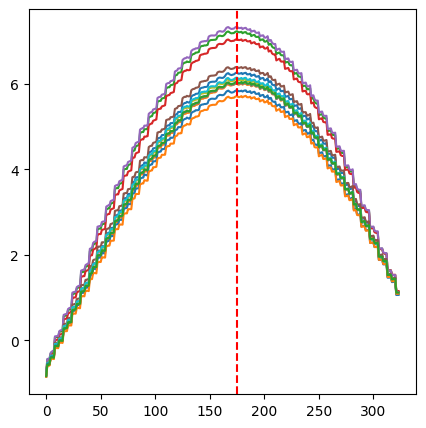

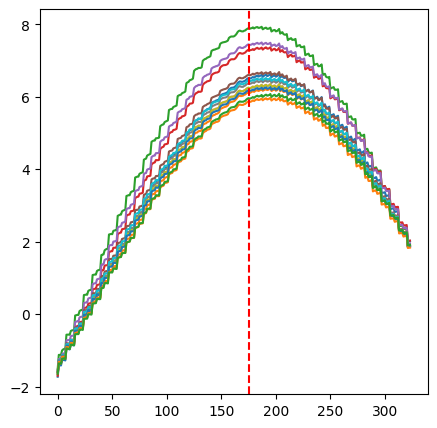

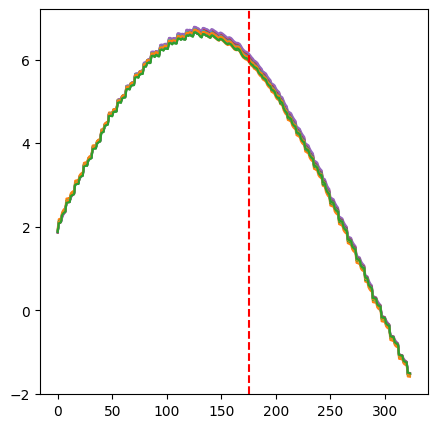

In [109]:
plt.figure(figsize=(5, 5))
for k, v in coeffs_dict_20.items():
    plt.plot(v, label=k)
    # plt.legend()
plt.axvline(x=175, color='red', linestyle='--')
plt.show()

plt.figure(figsize=(5, 5))
for k, v in coeffs_dict_40.items():
    plt.plot(v, label=k)
    # plt.legend()
plt.axvline(x=175, color='red', linestyle='--')
plt.show()

plt.figure(figsize=(5, 5))
for k, v in coeffs_dict_m40.items():
    plt.plot(v, label=k)
    # plt.legend()
plt.axvline(x=175, color='red', linestyle='--')
plt.show()

In [181]:
indicator_dict_20 = {k: v[175] for k, v in coeffs_dict_20.items()}
indicator_dict_40 = {k: v[175] for k, v in coeffs_dict_40.items()}
indicator_dict_m40 = {k: v[125] for k, v in coeffs_dict_m40.items()}

In [182]:
indicator_dict_20_refined = {
    'normal': indicator_dict_20['20kg_normal'],
    'backlash': (indicator_dict_20['20kg_backlash1'] + indicator_dict_20['20kg_backlash2']) / 2,
    'lackLubrication': (indicator_dict_20['20kg_lackLubrication1'] + indicator_dict_20['20kg_lackLubrication2']) / 2,
    'light_spalling': (indicator_dict_20['20kg_spalling1'] + indicator_dict_20['20kg_spalling2'] + indicator_dict_20['20kg_spalling3']) / 3,
    'medium_spalling': (indicator_dict_20['20kg_spalling3'] + indicator_dict_20['20kg_spalling4'] + indicator_dict_20['20kg_spalling5']) / 3,
    'heavy_spalling': (indicator_dict_20['20kg_spalling6'] + indicator_dict_20['20kg_spalling7'] + indicator_dict_20['20kg_spalling8']) / 3
}

In [183]:
indicator_dict_40_refined = {
    'normal': indicator_dict_40['40kg_normal'],
    'backlash': (indicator_dict_40['40kg_backlash1'] + indicator_dict_40['40kg_backlash2']) / 2,
    'lackLubrication': (indicator_dict_40['40kg_lackLubrication1'] + indicator_dict_40['40kg_lackLubrication2']) / 2,
    'light_spalling': (indicator_dict_40['40kg_spalling1'] + indicator_dict_40['40kg_spalling2'] + indicator_dict_40['40kg_spalling3']) / 3,
    'medium_spalling': (indicator_dict_40['40kg_spalling3'] + indicator_dict_40['40kg_spalling4'] + indicator_dict_40['40kg_spalling5']) / 3,
    'heavy_spalling': (indicator_dict_40['40kg_spalling6'] + indicator_dict_40['40kg_spalling7'] + indicator_dict_40['40kg_spalling8']) / 3
}

In [184]:
indicator_dict_m40_refined = {
    'normal': indicator_dict_m40['-40kg_normal'],
    'backlash': (indicator_dict_m40['-40kg_backlash1'] + indicator_dict_m40['-40kg_backlash2']) / 2,
    'lackLubrication': (indicator_dict_m40['-40kg_lackLubrication1'] + indicator_dict_m40['-40kg_lackLubrication2']) / 2,
    'light_spalling': (indicator_dict_m40['-40kg_spalling1'] + indicator_dict_m40['-40kg_spalling2'] + indicator_dict_m40['-40kg_spalling3']) / 3,
    'medium_spalling': (indicator_dict_m40['-40kg_spalling3'] + indicator_dict_m40['-40kg_spalling4'] + indicator_dict_m40['-40kg_spalling5']) / 3,
    'heavy_spalling': (indicator_dict_m40['-40kg_spalling6'] + indicator_dict_m40['-40kg_spalling7'] + indicator_dict_m40['-40kg_spalling8']) / 3
}

In [185]:
indicator_dict_20_refined

{'normal': 6.2661657512821325,
 'backlash': 6.620224739677965,
 'lackLubrication': 7.194280634819306,
 'light_spalling': 6.1568513580156825,
 'medium_spalling': 6.098974216186387,
 'heavy_spalling': 5.8762660237230095}

In [186]:
sorted_dict_20 = dict(sorted(indicator_dict_20_refined.items(), key=lambda item: item[1], reverse=True))
sorted_dict_40 = dict(sorted(indicator_dict_40_refined.items(), key=lambda item: item[1], reverse=True))
sorted_dict_m40 = dict(sorted(indicator_dict_m40_refined.items(), key=lambda item: item[1], reverse=True))

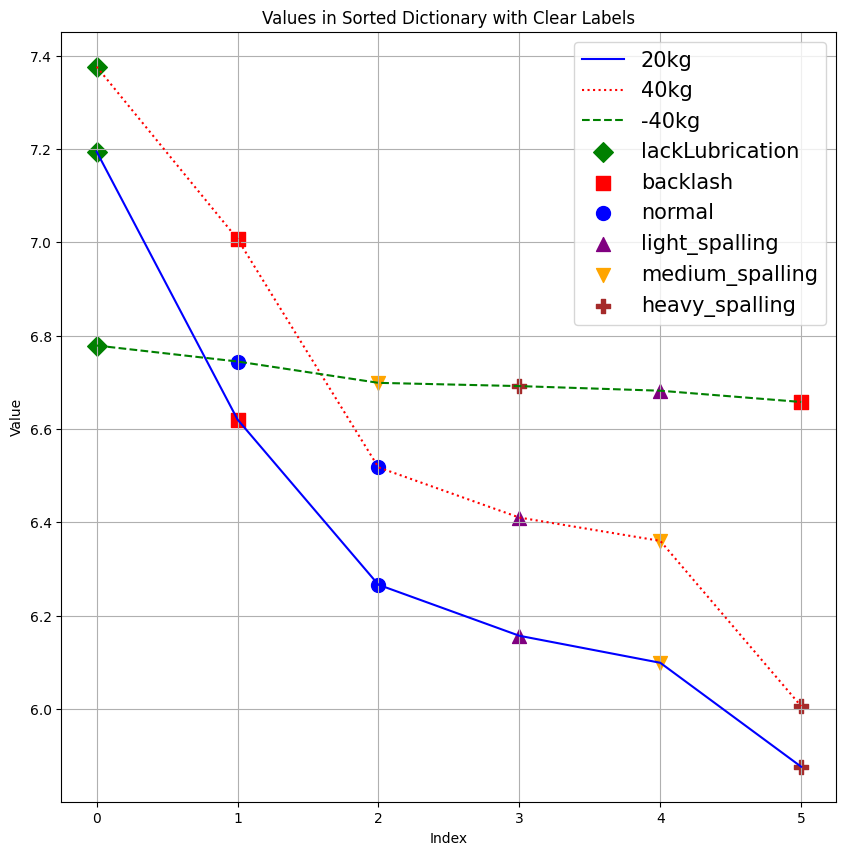

In [187]:
# Extract keys and values
keys_20 = list(sorted_dict_20.keys())
values_20 = list(sorted_dict_20.values())

keys_40 = list(sorted_dict_40.keys())
values_40 = list(sorted_dict_40.values())

keys_m40 = list(sorted_dict_m40.keys())
values_m40 = list(sorted_dict_m40.values())

labels = ['lackLubrication', 'backlash', 'normal', 'light_spalling', 'medium_spalling', 'heavy_spalling']
markers = {'normal': 'o', 'backlash': 's', 'lackLubrication': 'D', 'light_spalling': '^', 'medium_spalling': 'v', 'heavy_spalling': 'P'}
colors = {'normal': 'blue', 'backlash': 'red', 'lackLubrication': 'green', 'light_spalling': 'purple', 'medium_spalling': 'orange', 'heavy_spalling': 'brown'}

# Plot the curve
plt.figure(figsize=(10, 10))
plt.plot(values_20, label='20kg', linestyle='-', color='b')
plt.plot(values_40, label='40kg', linestyle=':', color='r')
plt.plot(values_m40, label='-40kg', linestyle='--', color='g')


for i, (key, value) in enumerate(zip(keys_20, values_20)):
    plt.scatter(i, value, marker=markers[key], color=colors[key], label=key, s=100)
for i, (key, value) in enumerate(zip(keys_40, values_40)):
    plt.scatter(i, value, marker=markers[key], color=colors[key], label=key, s=100)
for i, (key, value) in enumerate(zip(keys_m40, values_m40)):
    plt.scatter(i, value, marker=markers[key], color=colors[key], label=key, s=100)

# Creating a custom legend with unique handles
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # Remove duplicates
plt.legend(by_label.values(), by_label.keys(), loc='upper right', fontsize=15)

# Add title and labels
plt.title('Values in Sorted Dictionary with Clear Labels')
plt.xlabel('Index')
plt.ylabel('Value')

# Display plot
plt.grid(True)
plt.show()